# NLP

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

__Используемые библиотеки__

In [1]:
#!pip install vaderSentiment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import gc

# ML
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline, make_pipeline
from tqdm.notebook import tqdm
from pandarallel import pandarallel

# NLP
from imblearn.over_sampling import SMOTE
import nltk
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords as nltk_stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# MODELS
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

__Глобальные переменные__

In [3]:
state = np.random.RandomState(1234)
tqdm.pandas()

## Подготовка

### Загрузка данных

У меня довольно таки слабый ноутбук, поэтому я ограничивался 50% от всего датасета, но данное упущение легко исправить, просто убрав строку кода 
```python
data = data.sample(frac=0.5)
```
поэтому прошу понять и простить)

In [4]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')
    
data = data.drop('Unnamed: 0', axis=1)
#data = data.sample(frac=)    

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
data.sample(5)

,text,toxic
77894,"Levon Helm / Elton John \n\nHello, my feeling ...",0
148490,what is up with you editing all this less than...,0
45753,"196.2.124.251 \n\nI see this IP address, which...",0
118780,Gallery images in sections are fine when there...,0
6783,Try a 72-hour block \n\nThere could be lockout...,0


#### Вывод: 
Данные отображаются верно, но есть пару аспектов, которые стоит рассмотреть. Первый из них это столбец `Unnamed: 0`, он ничего не отображает, поэтому как признак он не представляет ценности, далее надо проверить датасет на пропуски и дубликаты.

### Пропуски

In [7]:
data.isna().sum()

text     0
toxic    0
dtype: int64

#### Вывод: 
Пропуски не обнаружены, двигаемся дальше

### Дубликаты

In [8]:
data.duplicated().sum()

0

#### Вывод:
Тут тоже успех, явных дубликатов нет

### Баланс классов в целевом признаке

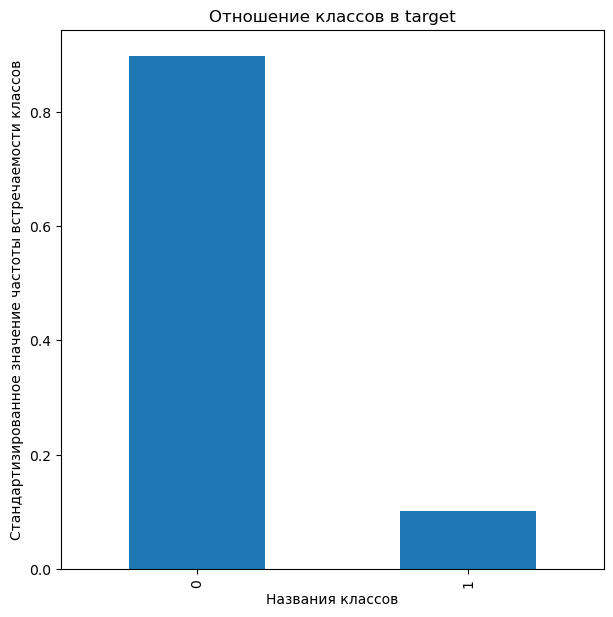

In [9]:
data['toxic'].value_counts(normalize=True).plot(kind='bar', figsize=(7, 7))
plt.title('Отношение классов в target')
plt.xlabel('Названия классов')
plt.ylabel('Стандартизированное значение частоты встречаемости классов');

In [10]:
data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

#### Вывод:
Явный дисбаланс, придется исправлять, используя либо downsampling, либо upsampling, но проще всего попробовать взвешенные классы в логистической регрессии. 

### Векторизация текстов

__Лемматизация__

In [11]:
# !pip install --upgrade Pillow
# !pip install pandarallel 
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

In [12]:
%%time

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

tqdm.pandas(desc="progress") 
pandarallel.initialize(progress_bar = True)
lemmatizer = WordNetLemmatizer()

data['text'] = data['text'].progress_apply(lambda x: x.lower())

data['lemm_text'] = data['text'].parallel_apply(
                    lambda x: " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(x)]))
data['lemm_text'] = data['lemm_text'].progress_apply(
                    lambda x: ' '.join(re.sub(r'[^a-zA-Z ]', ' ', x).split()))


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


progress:   0%|          | 0/159292 [00:00<?, ?it/s]

progress:   0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 9.4 s, sys: 1.45 s, total: 10.8 s
Wall time: 3min 31s


Сохраним получившийся датасет, чтобы упросить работу при дебаге

In [13]:
data.to_csv('tweets_lemm.csv')

###### Вывод:
Лемматизация и очистка датасета от знаков препинания выполнена успешно!

Сделаем облако слов, чтобы визуализировать самые частые слова в нашем датасете

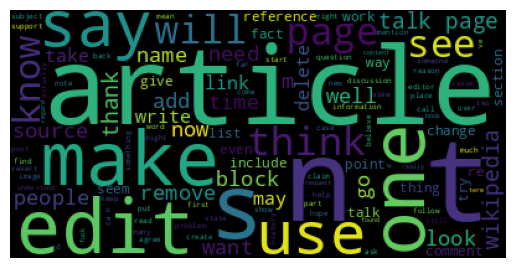

In [14]:
wordcloud = WordCloud().generate(' '.join(data['lemm_text']))
plt.imshow(wordcloud)
plt.axis('off');

### Создадим новые признаки
которые будут описывать степень негативности, нейтральности и позитивности используемых слов в данных объектах, а также добавим длину текста

In [15]:
def sentiment_scores(row):
 
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(row['lemm_text'])
    
    row['neg'], row['neu'], row['pos'] = sentiment_dict['neg'], sentiment_dict['neu'], sentiment_dict['pos']
    row['length'] = len(row['lemm_text'])
    
    return row

In [16]:
data = data.parallel_apply(sentiment_scores, axis=1)

Посмотрим на результат:

In [17]:
data.sample(3)

,text,toxic,lemm_text,neg,neu,pos,length
51434,"i'm going to be honest with you, i'm not going...",1,i m go to be honest with you i m not go to pas...,0.108,0.740,0.151,3290
154294,""" (utc)\n\n solar intensity due to proximity ...",0,utc solar intensity due to proximity ratio bet...,0.017,0.888,0.095,1428
44885,it also does not allow that h and h came to th...,0,it also do not allow that h and h come to the ...,0.035,0.925,0.040,801


#### Вывод:
Создали новые признаки, однако теперь стоит их стандартизировать

## Обучение

__Разбивка датасета на подвыборки__

In [18]:
features = data.drop(['toxic', 'text'], axis=1)
target = data['toxic']
features_train, features_test, target_train, target_test = train_test_split(features, target, stratify=target,
                                                                            test_size=0.25, random_state=state)

При использовании кросс-валидации выборки должны разделяться и обрабатываться по отдельности: обучение и применение к трейну, затем обученную модель или трансформер применяем к валидационной выборке. Так должно быть при каждом разделении (фолде). По этой причине создадим пайплайны.

In [19]:
# nltk.download('stopwords')
# 'XGB': XGBClassifier(random_state=state)
stopwords = set(nltk_stopwords.words('english'))

models = {'Log_reg': LogisticRegression(random_state=state), 
          'SGDClassifier': SGDClassifier(random_state=state), 
          'PassiveAgressiveClassifier': PassiveAggressiveClassifier(random_state=state),
          }

cross_val_scores = []

def make_pipes(model):
    
    new_features = ['length', 'pos', 'neg', 'neu']
    features = ColumnTransformer(
                    [("text_preprocess", TfidfVectorizer(stop_words=list(stopwords), dtype=np.float32), "lemm_text"),
                     ("new_features_preprocess", StandardScaler(), new_features),
                    ])
    pipe = make_pipeline(features, 
                         SMOTE(random_state=state),
                         model)
    
    cvs = cross_val_score(pipe, features_train[['lemm_text', 'length', 'pos', 'neg', 'neu']], target_train, scoring='f1')
    cross_val_scores.append(round(cvs.mean(), 3))
    return 0

In [20]:
from tqdm import tqdm

for model in tqdm(models.values()):
    make_pipes(model)

100%|█████████████████████████████████████████████| 3/3 [02:30<00:00, 50.18s/it]


Теперь создадим таблицу, в которой записаны значение f1-метрики на кросс-валидации и на тесте для разных моделей.

In [21]:
results = pd.DataFrame([cross_val_scores], columns=models.keys(), index=['train']).transpose()
results

,train
Log_reg,0.751
SGDClassifier,0.719
PassiveAgressiveClassifier,0.677


Остается только один вопрос: можно ли потюнинговать модели, чтобы улучшить метрику? Для этого можно использовать GridSearchCV

In [22]:
grid_scores = []
best_params = []
models_with_params = {'LogisticRegression': 
                      [LogisticRegression(), {
                          'random_state': [state]
                     }], 
                      'SGDClassifier': 
                      [SGDClassifier(), {
                          'max_iter': [10000, 15000, 20000],
                          'random_state': [state],
                          'alpha':[0.00001, 0.000001]
                     }], 
                      'PassiveAggressiveClassifier': 
                      [PassiveAggressiveClassifier(), {
                          'random_state': [state],
                          'C' : [0.003, 0.03, 0.0001], 
                          'loss': ['hinge', 'squared_hinge'],
                          'max_iter': [150, 250, 450]
                      }]
                      }

def make_pipe_v2(model, name):
      
    new_features = ['length', 'pos', 'neg', 'neu']
    features = ColumnTransformer(
                    [("text_preprocess", TfidfVectorizer(stop_words=list(stopwords), dtype=np.float32), "lemm_text"),
                     ("new_features_preprocess", StandardScaler(), new_features),
                    ])
    pipe = make_pipeline(features, 
                         SMOTE(random_state=state),
                         model[0])

    params = model[1]
    new_params = {name.lower() + '__' + key: params[key] for key in params}
    grid_pipe = GridSearchCV(pipe, param_grid=new_params, cv=4, scoring='f1')
    grid_pipe.fit(features_train[['lemm_text', 'length', 'pos', 'neg', 'neu']], target_train)
    grid_scores.append(round(grid_pipe.best_score_, 3))
    best_params.append(grid_pipe.best_estimator_)
    return 0

In [23]:
from tqdm import tqdm

for model in tqdm(models_with_params.items()):
    make_pipe_v2(model[1], model[0])

100%|████████████████████████████████████████████| 3/3 [17:19<00:00, 346.61s/it]


In [24]:
results['grid_train'] = grid_scores

In [25]:
results

,train,grid_train
Log_reg,0.751,0.750
SGDClassifier,0.719,0.750
PassiveAgressiveClassifier,0.677,0.759


#### Вывод:
По итогам, лучшей моделью является PassiveAgressiveClassifier, метрика на этой модели составила 0,76

### Тест лучшей модели

In [38]:
x = results.loc[results['grid_train'] == results['grid_train'].max()]
if x.index == 'PassiveAgressiveClassifier':
    ind = -1
elif x.index == 'SGDClassifier':
    ind = 1
else:
    ind = 0
x

,train,grid_train
PassiveAgressiveClassifier,0.677,0.759


In [40]:
pred = best_params[ind].predict(features_test)
print('F1 на тестовой выборке на лучшей модели по итогам кроссвалидации:', round(f1_score(target_test, pred), 3))

F1 на тестовой выборке на лучшей модели по итогам кроссвалидации: 0.756


#### Вывод:
Была подобрана модель `PassiveAgressiveClassifier`, которая по показала результат выше заданного порога

## Выводы

NLP -- очень трудоемкая задача, которая требует больших мощностей. В процессе данной работы были проделаны следущие шаги:
- Загрузили данные и провели коротенький EDA
- Провели лемматизацию, используя WordNetLemmatizer (с POS-тегами), и очистили текст от знаков пунктуации и чисел
- Создали Pipeline, в котором провели векторизацию лемматизированного текста, SMOTE апсемлинг и обучение целого списка классификаторов
- Добавили в нашу функцию GridSearchCV, который прекрасно дружит с Pipeline'ом
- Выбрали лучшу модель по итогам кросс-валидации и получили метрику на тестовой выборке, которая оказалась выше заданного порога.